In [16]:
import matplotlib.pyplot as plt
import numpy as np
import magpylib as magpy    
import scipy.constants as cts
import pylcp 

In [17]:
tfmot = magpy.Collection()
N = 4
angles = np.linspace(0,360,N,endpoint=False)
pol = [0,180,0,180]
l = 35
halbach = magpy.Collection()
mystyle = mstyle = dict(
    mode="color+arrow",
    color=dict(north="magenta", middle="white", south="turquoise"),
    arrow=dict(width=2, color="k"),
)
for a in range(len(angles)):
    cube= magpy.magnet.Cuboid(
    dimension=(8,6,80),
    polarization=(1.17,0,0),
    position=(30+l,0,0),
    style_magnetization = mystyle)
    cube.rotate_from_angax(angles[a], 'z',anchor = 0)
    cube.rotate_from_angax(pol[a], 'z')

    tfmot.add(cube)

magpy.show(tfmot, backend='plotly',)

In [18]:
zeeman_prof = magpy.Collection()
j = 30
n = 8
a = 0# distance it circles aroundthe center 
c = 30 #angle of first bar
d =  24#angle of second bar
b = -190# distnace the two section of the array are apart from each other
k = -100 #the first and second magnent are apart
e = 40
l = -5
p= -20# distance the thrid and 4th magnet are apart from each other
m  = -42
mystyle = mstyle = dict(
    mode="color+arrow",
    color=dict(north="magenta", middle="white", south="turquoise"),
    arrow=dict(width=2, color="k")
)
angles = np.linspace(0, 360, n, endpoint=False)
for i in angles:
    cube1= magpy.magnet.Cuboid(
    dimension=(6,6,125),
    polarization=(-(1.080),0,0),
    position=(70+a+l,0,140+k))
    cube2 = magpy.magnet.Cuboid(dimension= (4,4,25),
    polarization=(-1.17,0,0),
    position=(60+a+l,0,50+e),style_magnetization = mystyle)
    cube3= magpy.magnet.Cuboid(
    dimension=(6,6,125),
    polarization=(1.08,0,0),
    position=(91.5+m,0,320+b))
 
#     cube5 = magpy.magnet.Cuboid(dimension= (4,4,25),
#     polarization=(-1.17,0,0),
#     position=(90+a+p+m,0,190))

#     cube6 = magpy.magnet.Cuboid(dimension= (4,4,25),
#     polarization=(-1.17,0,0),
#     position=(80+a+p+m,0,200),
# )
   


    cube1.rotate_from_angax(i, 'z')
    cube1.rotate_from_angax(c, 'y',)
    cube1.rotate_from_angax(i, 'z', anchor=0)
 
 
    cube2.rotate_from_angax(i, 'z',anchor = 0)
    cube2.rotate_from_angax(i, 'z')
    cube3.rotate_from_angax(i, 'z', anchor=0)
    cube3.rotate_from_angax(-d, 'y')
    cube3.rotate_from_angax(i, 'z')
  
    #cube4.rotate_from_angax(i, 'z', anchor=0)
    #cube4.rotate_from_angax(-d, 'y')
    #cube4.rotate_from_angax(i, 'z')
    

    zeeman_prof.add(cube1)
    zeeman_prof.add(cube2)
    zeeman_prof.add(cube3)
    #zeeman_prof.add(cube4)
    # zeeman_prof.add(cube5)
    # zeeman_prof.add(cube6)
    j = j+1


tfmot = magpy.Collection()
N = 4
angles = np.linspace(0,360,N,endpoint=False)
pol = [0,180,0,180]
l = 35
halbach = magpy.Collection()
mystyle = mstyle = dict(
    mode="color+arrow",
    color=dict(north="magenta", middle="white", south="turquoise"),
    arrow=dict(width=2, color="k"),
)
for a in range(len(angles)):
    cube= magpy.magnet.Cuboid(
    dimension=(8,6,80),
    polarization=(1.17,0,0),
    position=(30+l,0,270),
    style_magnetization = mystyle)
    print(a)
    cube.rotate_from_angax(angles[a], 'z',anchor = 0)
    cube.rotate_from_angax(pol[a], 'z')

    tfmot.add(cube)

b_tot = magpy.Collection()
b_tot.add(zeeman_prof,tfmot,override_parent=True)
b_tot.show()

0
1
2
3


KeyboardInterrupt: 

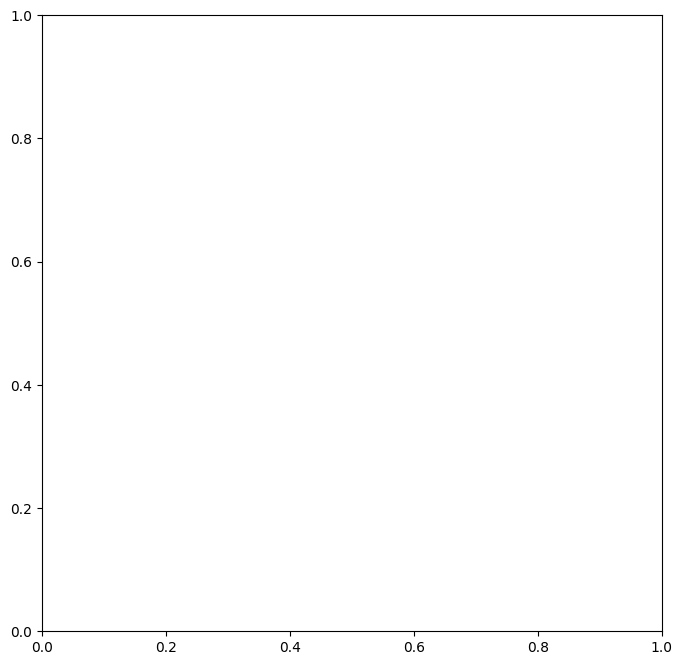

In [19]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
grid = np.mgrid[-35:35:1000j, -35:35:1000j, 0:0:10j].T[0]
X, Y, _ = np.moveaxis(grid, 2, 0)

B = 1e3*tfmot.getB(grid)
Bx, By, _ = np.moveaxis(B, 2, 0)
Bamp = np.linalg.norm(B, axis=2)

pc = ax.contourf(X, Y, Bamp, levels=50, cmap="coolwarm")
ax.streamplot(X, Y, Bx, By, color="k", density=1.5, linewidth=1)

# Add colorbar
fig.colorbar(pc, ax=ax, label="|B|(mT)")

# Figure styling
ax.set(
    xlabel="x-(mm)",
    ylabel="y-(mm)",
    aspect=1,)



plt.show()

In [ ]:
2*np.sqrt(2*9.81)

8.858893836140041

In [ ]:
4*np.sqrt(np.sqrt(2*9.81)) + np.sqrt(128-40/3*np.sqrt(2*9.81))/3

11.186185208682579

In [ ]:
def v_avg(m,T):
    return np.sqrt(8*cts.k*T/(np.pi*m))

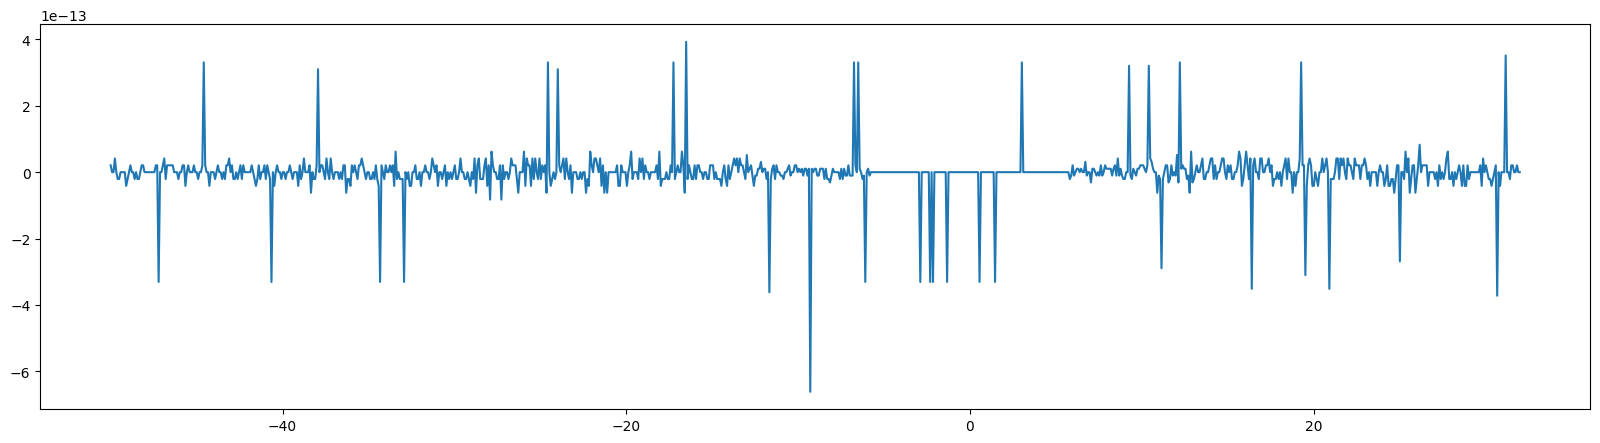

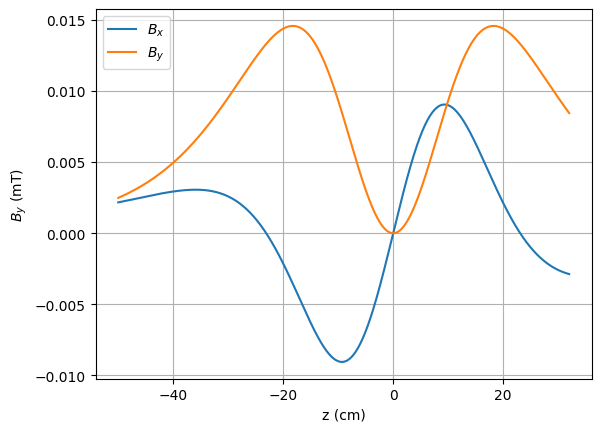

In [ ]:
L = 16
z = np.linspace(-50,2*L,1000)
b_y = []
b_z = []
b_x = []
for i in z:
    b_x.append(tfmot.getB([0,i*10,0])[0])
    b_y.append(tfmot.getB([0,i*10,0])[1])
    b_z.append(tfmot.getB([0,i*10,0])[2])

fig,ax = plt.subplots(1,1,figsize=(20,5))    
plt.plot(z,np.array(b_x)*1e3)
plt.figure()
plt.plot(z,np.array(b_y)*1e3)
plt.plot(z,np.array(b_z)*1e3)
#plt.yticks([-20,0,20,40])
#plt.xticks([-0.1,0,0.1,0.2,0.3,0.4])
plt.xlabel('z (cm)')

plt.ylabel('$B$ (mT)')
plt.legend(['$B_x$','$B_y$','$B_z$','Analytical'])  
plt.ylabel('$B_y$ (mT)')
plt.grid()

In [ ]:
mass_lab = 173*cts.value('atomic mass constant') # YB-173 mass in kg
v_a = v_avg(mass_lab,216.85)
sd = np.sqrt(cts.k*216.85/mass_lab)
vel = np.random.normal(v_a,sd,1000000)
klab = 2*np.pi*25068.2222# Lab wavevector (without 2pi) in cm^{-1}   # Lifetime of 6P_{3/2} state (in seconds)
gammalab = (1.93*1e8)
v0 =max(vel)
Blab = -67*1e-3#(v0*cts.hbar*(klab*100))/cts.value('Bohr magneton')
b_0L =  48*1e-3
# (v0*cts.hbar*(klab*100))/cts.value('Bohr magneton')/2
# T # About 15 G/cm is a typical gradient for Rb
L = 16
x0 = 1/klab  # cm
t0 = 1/gammalab  # s
#100*(mass_lab*(v0**2))/(0.5*cts.hbar*(klab*100)*gammalab) +5
print(Blab, L,v0,b_0L)

-0.067 16 676.8208277129978 0.048


In [ ]:
x0 = 1/klab  # cm
t0 = 1/gammalab  # s

mass = mass_lab*(x0*1e-2)**2/cts.hbar/t0

# And now our wavevector, decay rate, and magnetic field gradient in these units:
k = klab*x0
gamma = gammalab*t0
alpha = cts.value('Bohr magneton')*Blab*t0/cts.hbar
b_0 = cts.value('Bohr magneton')*b_0L*t0/cts.hbar 
l = L/x0 

print(x0, t0, mass, k, gamma, alpha,b_0)

6.348872362073421e-06 5.181347150259067e-09 2119.188266564296 1.0 1.0 -30.52874111941582 21.871336921372524


In [ ]:
# Define the atomic Hamiltonian:
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
0, 5/2, 0,  	-0.2592,
    Ahfs = 0, Bhfs=0, Chfs=0,
    muB=1)# ground state 1s0
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
1, 5/2, 1.035,	-0.2592,
    Ahfs=59.52*1e6,Bhfs = 601.87*1e6 , Chfs= 0,
    muB=1) #excited state 1p1

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(0, 1, 5/2)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))
hamiltonian_D2 = pylcp.hamiltonian(mass = mass)
hamiltonian_D2.add_H_0_block('g', H_g_D2)
hamiltonian_D2.add_H_0_block('e', H_e_D2)
hamiltonian_D2.add_d_q_block('g', 'e', dijq_D2, gamma = gamma, k = k)
hamiltonian_D2.add_mu_q_block('g', mu_q_g_D2)
hamiltonian_D2.add_mu_q_block('e', mu_q_e_D2)



#ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)
# Define the atomic Hamiltonian:
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
0, 5/2, 0,  	-0.2592,
    Ahfs = 0, Bhfs=0, Chfs=0,
    muB=1)# ground state 1s0
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
1, 5/2, 1.035,	-0.2592,
    Ahfs=59.52*1e6,Bhfs = 601.87*1e6 , Chfs= 0,
    muB=1) #excited state 1p1

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(0, 1, 5/2)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))
hamiltonian_D2 = pylcp.hamiltonian(mass = mass)
hamiltonian_D2.add_H_0_block('g', H_g_D2)
hamiltonian_D2.add_H_0_block('e', H_e_D2)
hamiltonian_D2.add_d_q_block('g', 'e', dijq_D2, gamma = gamma, k = k)
hamiltonian_D2.add_mu_q_block('g', mu_q_g_D2)
hamiltonian_D2.add_mu_q_block('e', mu_q_e_D2)



#ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)


s = 1
det = 5

# Define the laser beams:
laserBeams = pylcp.laserBeams([
    {'kvec':np.array([0, 1, 0]), 's': s,'pol_coord':'spherical', 'pol':  -1, 'delta': (E_e_D2[2]-E_g_D2[0]) + det*gamma},
     {'kvec':np.array([0, -1, 0]), 's': s,'pol_coord':'spherical', 'pol': -1, 'delta': (E_e_D2[2]-E_g_D2[0]) + det*gamma},
      {'kvec':np.array([1, 0, 0]), 's': s,'pol_coord':'spherical', 'pol': 1, 'delta': (E_e_D2[2]-E_g_D2[0]) + det*gamma},
     {'kvec':np.array([-1, 0, 0]), 's': s,'pol_coord':'spherical', 'pol': 1, 'delta': (E_e_D2[2]-E_g_D2[0]) + det*gamma}],
    beam_type=pylcp.infinitePlaneWaveBeam) 

#linGrad =  pylcp.magField(lambda R: mag(R,b_0,alpha,l))
bf_mot = lambda R:b_tot.getB(R*10*x0)*cts.value('Bohr magneton')*t0/cts.hbar 
linGrad = pylcp.magField(lambda R: bf_mot(R))

In [ ]:
327/50

6.54

In [ ]:
rateeq = pylcp.rateeq(laserBeams, linGrad, hamiltonian_D2, include_mag_forces=True)

In [ ]:
vc = x0/t0*1/(100)
Fc = cts.hbar*klab*gammalab
x = np.arange(-5,5, 0.05)/x0
z = np.arange(-3, 3, 0.05)/x0
y = np.arange(-3, 3, 0.05)/x0
z = np.arange(270, 300, 0.05)/x0
v= np.arange(-144, 144, 4)/vc

X,Y,Z, V = np.meshgrid(x,y,z,v)



Rvec = np.array([X,Y,Z])
Vvec = np.array([np.zeros(X.shape),V, np.zeros(V.shape)])

rateeq.generate_force_profile(Rvec, Vvec, name='Fz', progress_bar=True)


KeyboardInterrupt: 

C:\Users\benfo\AppData\Local\Temp\ipykernel_29448\1990042205.py:2: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Text(0.5, 1.0, 'Contour plot of position vs velocity and force')

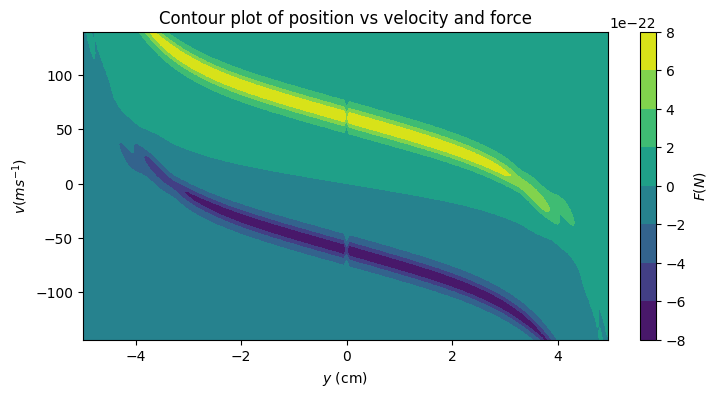

In [ ]:

fig,ax = plt.subplots(1, 1, figsize=(8, 4)) 
cmap_reversed = plt.cm.get_cmap('viridis_r')
Fc = gammalab*cts.hbar*klab
im1 = ax.contourf(np.array(x)*x0, np.array(v)*vc,rateeq.profile['Fz'].F[1]*Fc)
fig.subplots_adjust(left=0.08, wspace=0.2)
cb1 = plt.colorbar(im1)
cb1.set_label('$F(N)$')
ax.set_xlabel('$y$ (cm)')
ax.set_ylabel('$v (ms^{-1})$')
plt.title('Contour plot of position vs velocity and force')

In [ ]:
velocitiesz =  np.random.normal(v_a,sd_yb, 100) 

z_n  = []
vz_n = []
x_n =  []
y_n =  []
for j in range(len(velocitiesz)):   
    t_max = 0.0010/t0
    t_span = np.linspace(0,t_max,10000)
    z_t = []
    v_t = []
    y_t = []
    x_t = []
    v_0z = velocitiesz[j]/vc
    v_0y = velocitiest[j]
    v_0x = velocitiest[j] 
    v_ind = list(np.array(v))
    x_ind = list(np.array(x))
    sz = 0
    sx = 0
    sy = 0
    di = 0
    dt  =  0 
    for i in range(len(t_span)):
        dt = t_span[i] - di
        
        c = v_ind.index(find_nearest_value(v_ind,v_0))

        d = x_ind.index(find_nearest_value(x_ind,sz))

        a = ((force_profiles[key][c][d]))/mass

        sz = (1/2)*a*(dt**2) + v_0z*dt + sz
        if random_recoil == 'yes':
            recoil = dt*(a)*random_sphere(np.random.uniform(-1,1),np.random.uniform(0,2*np.pi))
        else: 
            recoil = [0,0,0]
        v_0z = v_0z + a*dt - recoil[2]

        sx = sx + v_0x*(dt*t0) - recoil[0]

        sy = sy + v_0y*(dt*t0) - recoil[1]

        z_t.append(sz)

        x_t.append(sx)

        y_t.append(sy)
        
        v_t.append(v_0z)
            
        di = t_span[i]

    z_n.append(z_t)
    x_n.append(x_t)
    y_n.append(y_t)
    vz_n.append(v_t) 